# Audio annotations

Annotations are labels for audio data, typically formatted as "boxes" in time and frequency around calls of interest.

When used for machine learning, each annotation box is usually labeled with one or more *classes*, categories that the machine learning algorithm should predict the presence of, such as  species or call types. Labels can also include other attributes useful for filtering data, like call quality.

This notebook demonstrates how to use the `annotations` module of OpenSoundscape to:

- Load annotations from Raven files

- Edit and save annotations

- Create a set of labels for training machine learning models

The audio recordings used in this notebook were recorded by Andrew Spencer and are available under a Creative Commons License ([CC BY-NC-ND 2.5](https://creativecommons.org/licenses/by-nc-nd/2.5/)) from https://xeno-canto.org. Annotations were performed in Raven Pro software by our team.

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/annotations.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/annotations.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [ ]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install opensoundscape==0.12.0 ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0

## Setup

### Imports
We will need the `BoxedAnnotation` class from OpenSoundscape. Also import `Audio` and `Spectrogram` classes for the purpose of the tutorial.

In [19]:
# OpenSoundscape imports
from opensoundscape import Audio, Spectrogram
from opensoundscape.annotations import BoxedAnnotations

# General-purpose packages
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

## Download example files
Download a set of example audio files and Raven annotations:

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip both `annotation_Files.zip` and `mp3_Files.zip` from the https://datadryad.org/stash/dataset/doi:10.5061/dryad.d2547d81z  
- Move the unzipped contents into a subfolder of the current folder called `./annotated_data/`

In [20]:
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O annotation_Files.zip https://datadryad.org/stash/downloads/file_stream/641805
!wget -O mp3_Files.zip https://datadryad.org/stash/downloads/file_stream/641807
!mkdir annotated_data
!unzip -q annotation_Files.zip -d ./annotated_data/annotation_Files
!unzip -q mp3_Files.zip -d ./annotated_data/mp3_Files

--2025-02-28 12:36:18--  https://datadryad.org/stash/downloads/file_stream/641805
Resolving datadryad.org (datadryad.org)... 44.236.210.21, 54.186.9.89, 44.231.126.195, ...
Connecting to datadryad.org (datadryad.org)|44.236.210.21|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-02-28 12:36:18 ERROR 403: Forbidden.

--2025-02-28 12:36:19--  https://datadryad.org/stash/downloads/file_stream/641807
Resolving datadryad.org (datadryad.org)... 54.186.9.89, 44.231.126.195, 35.161.56.100, ...
Connecting to datadryad.org (datadryad.org)|54.186.9.89|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-02-28 12:36:19 ERROR 403: Forbidden.

mkdir: annotated_data: File exists
[annotation_Files.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this arch

## Load a single Raven annotation table

We can use the `BoxedAnnotation` class's `from_raven_files()` method to load a Raven `.selections.txt` file into OpenSoundscape. This table contains the frequency and time limits of "boxes" representing each annotation that was created in Raven. 

Note that we need to specify the name of the column containing annotations, since it can be named anything in Raven. The column will be renamed to "annotation". 

This table looks a lot like what you would see in the Raven interface.

In [ ]:
# Specify an audio file and corresponding raven annotation file
audio_file = "./annotated_data/mp3_Files/Recording_2/Recording_2_Segment_01.mp3"
annotation_file = "./annotated_data/annotation_Files/Recording_2/Recording_2_Segment_01.Table.1.selections.txt"

Let's look at a spectrogram of the audio file to see what we're working with.

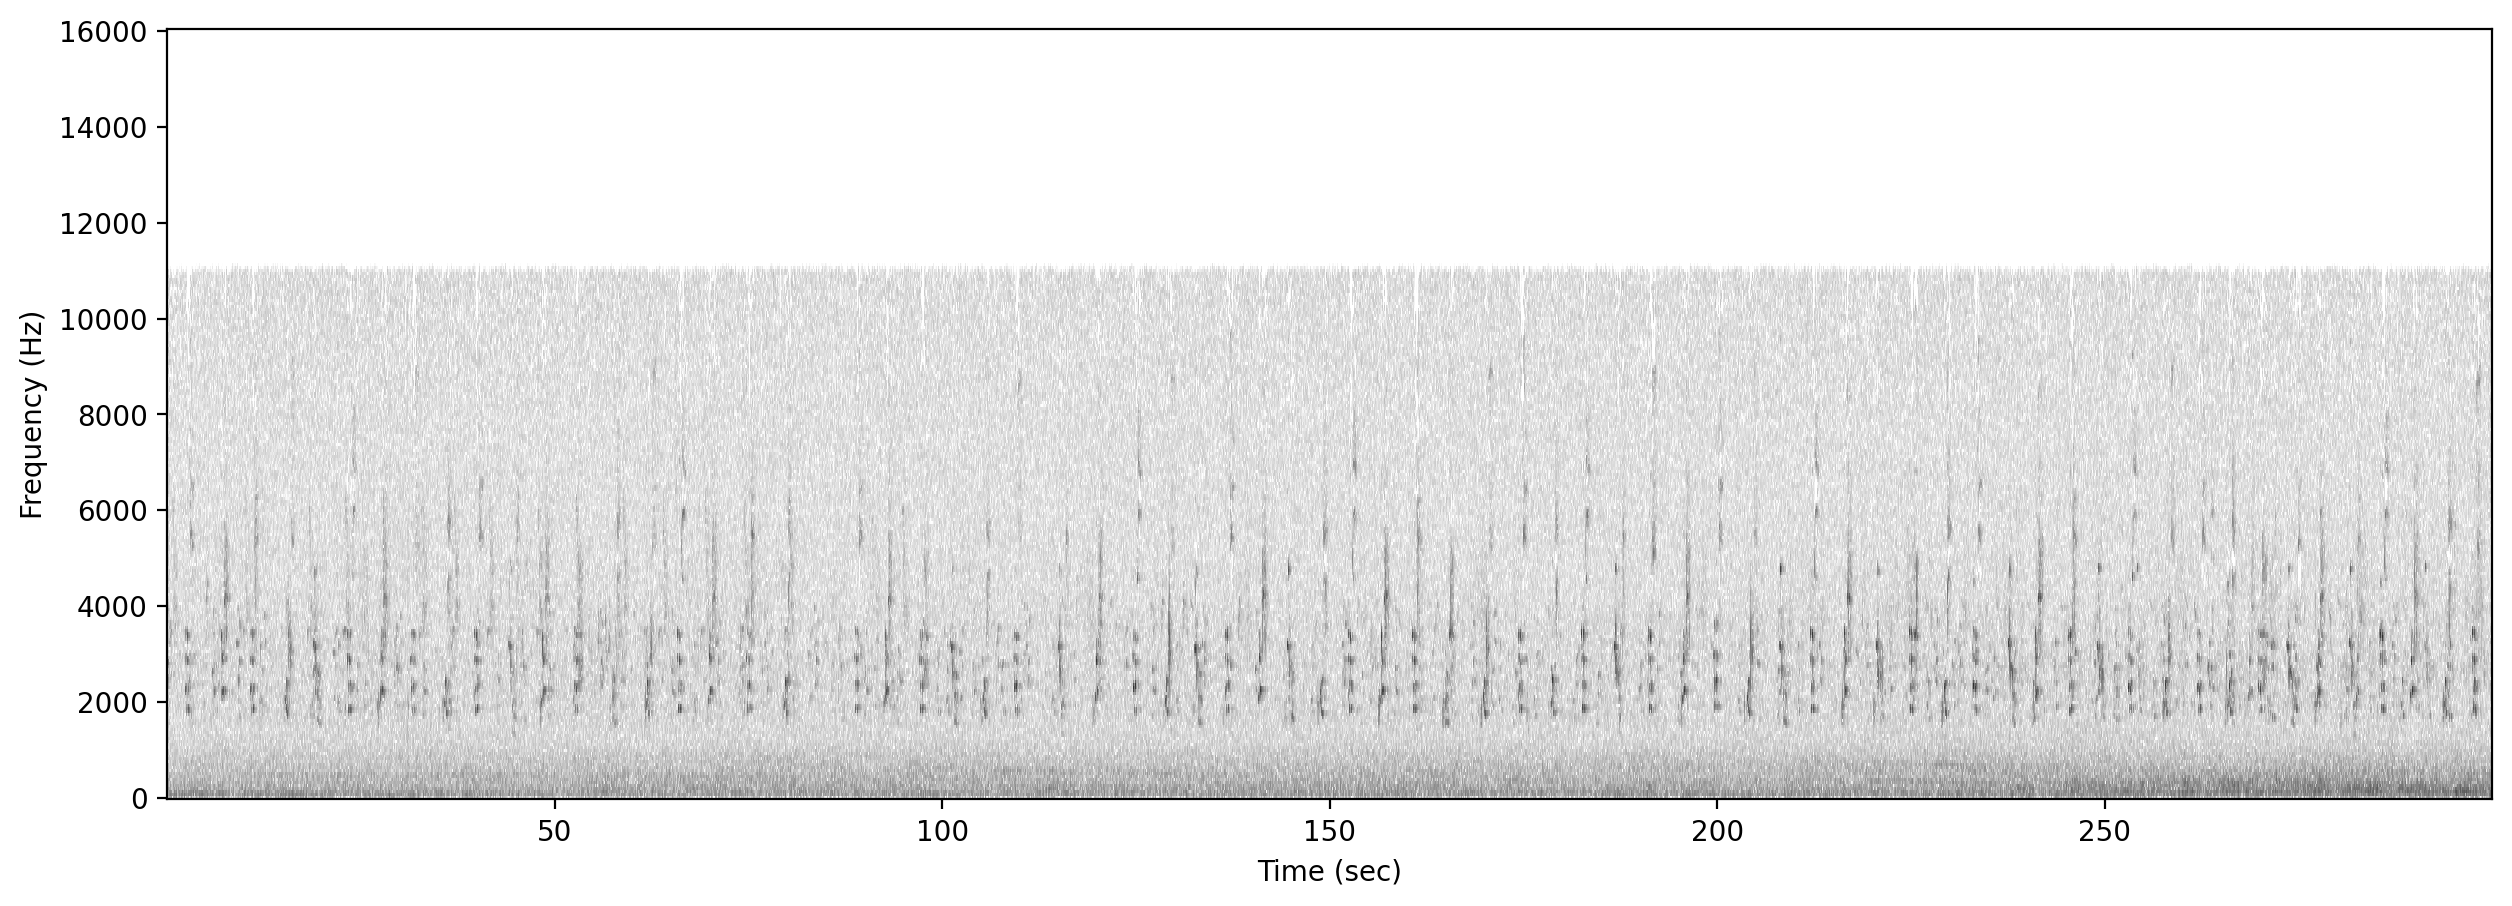

In [22]:
Spectrogram.from_audio(Audio.from_file(audio_file)).plot()

Note that the `from_raven_files()` method expects annotation files and audio files each in their own list--you cannot pass a single annotation file. So, wrap the filenames in lists:

In [23]:
annot_list = [annotation_file]
audio_list = [audio_file]

Now, let's load the annotations from the Raven annotation file.

If you **do not have a column of text labels/annotations**, e.g.,  if you are annotating the sounds of a single species, pass the argument `annotation_column_idx=None`. The resulting dataframe will have an empty `annotation` column. This column is needed for later steps in the tutorial.

In [ ]:
# Create an object from Raven file
annotations = BoxedAnnotations.from_raven_files(
    raven_files=annot_list,
    audio_files=audio_list,
    annotation_column="Species",  # Put None if you don't have an annotation column
)

# Inspect the object's .df attribute
# which contains the table of annotations
annotations.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
0,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,0.000000,0.879221,1578.1,4339.9,1,1,Spectrogram 1
1,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,EATO,0.376752,1.415012,2923.1,6608.6,2,1,Spectrogram 1
2,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,2.229848,3.592289,1683.9,10008.3,3,1,Spectrogram 1
3,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,EATO,4.957538,5.417527,2986.6,4670.5,4,1,Spectrogram 1
4,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,5.724186,6.499594,1398.0,4162.2,5,1,Spectrogram 1


We could instead choose to only load the necessary columns (`start_time`, `end_time`, `low_f`, `high_f`, and `annotation`) using the argument `keep_extra_columns=None`. 

In this example, we use `keep_extra_columns=['Notes']` to keep only the Notes column.

In [ ]:
annotations_noextras = BoxedAnnotations.from_raven_files(
    [annotation_file],
    annotation_column="Species",
    keep_extra_columns=["Notes"],
    audio_files=[audio_file],
)

annotations_noextras.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Notes
0,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,0.000000,0.879221,1578.1,4339.9,NaN
1,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,EATO,0.376752,1.415012,2923.1,6608.6,NaN
2,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,2.229848,3.592289,1683.9,10008.3,NaN
3,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,EATO,4.957538,5.417527,2986.6,4670.5,NaN
4,./annotated_data/mp3_Files/Recording_2/Recordi...,./annotated_data/annotation_Files/Recording_2/...,WOTH,5.724186,6.499594,1398.0,4162.2,NaN


## Load multiple Raven annotation tables

In practice, we have tons of audio files with their corresponding Raven files. We need to:

* Pair up all the audio files with their Raven annotation files

* Create a dataframe of labels corresponding to short segments of each audio file

Let's walk through the steps required to do this. 

In [26]:
# Set the current directory to where the dataset is downloaded

dataset_path = Path("./annotated_data/")

Get a list of all the selection table files using `glob`, which finds all the files matching the "wildcard" pattern signified by the asterisks.

In [27]:
# Make a list of all of the selection table files
selections = glob(f"{dataset_path}/Annotation_Files/*/*.txt")

Because all of our audio files have the same names as selection tables, just with a different extension (`.mp3` instead of `.Table.1.selections.txt`), we can easily create a list of all the associated audio files.

For this reason, we recommend keeping the names of the audio files and their associated selection tables the same.

In [ ]:
# create a list of audio files, one corresponding to each Raven file
# (Audio files have the same names as selection files with a different extension)
audio_files = [
    f.replace("Annotation_Files", "Recordings").replace(
        ".Table.1.selections.txt", ".mp3"
    )
    for f in selections
]

Above, we used the `BoxedAnnotations.from_raven_files()` class to load one audio file and its annotation, but we can also use it to load multiple audio files and their annotations. 

Do this by passing the method the list of Raven files and the corresponding list of audio files that we just generated.

**Note of caution:** The method we used above to generate the list of audio files made sure that the lists of audio files was the same length and order as the list of annotation files, both in the identical order. The `from_raven_files()` function assumes that these two lists exactly correspond in that way.

In [ ]:
all_annotations = BoxedAnnotations.from_raven_files(
    selections, annotation_column="Species", audio_files=audio_files
)
all_annotations.df.head(2)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:333: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
0,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,BTNW,0.913636,2.202273,4635.1,7439.0,1,1,Spectrogram 1
1,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,EATO,2.236363,2.693182,3051.9,4101.0,2,1,Spectrogram 1


You can also use `from_raven_files()` without inputting a list of audio files, although this is less useful for creating a machine learning dataset (as we'll describe later in the tutorial).

In [ ]:
annotations_no_audio = BoxedAnnotations.from_raven_files(
    selections, annotation_column="Species"
)
annotations_no_audio.df.head(2)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:333: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
0,NaN,annotated_data/Annotation_Files/Recording_1/Re...,BTNW,0.913636,2.202273,4635.1,7439.0,1,1,Spectrogram 1
1,NaN,annotated_data/Annotation_Files/Recording_1/Re...,EATO,2.236363,2.693182,3051.9,4101.0,2,1,Spectrogram 1


The `BoxedAnnotation` DataFrame contains one row per annotation created in Raven pro. 

How many annotations do we have of each species?

In [31]:
all_annotations.df.annotation.value_counts()

annotation
EATO    5238
WOTH    1826
BCCH    1262
BTNW    1058
TUTI     885
NOCA     884
REVI     592
AMCR     534
BLJA     519
OVEN     404
COYE     365
BGGN     320
SCTA     290
AMRE     274
KEWA     194
BHCO     176
BHVI     174
HETH     162
RBWO     145
BAWW     142
HOWA      92
NOFL      71
AMGO      62
CARW      48
BWWA      47
LOWA      46
RCKI      35
YBCU      33
SWTH      31
WBNU      28
RBGR      27
WITU      24
AMRO      22
DOWO       8
VEER       6
BBWA       4
NAWA       4
HAWO       3
EAWP       3
CSWA       3
RWBL       2
CANG       2
BAOR       2
CEDW       1
CORA       1
RSHA       1
PIWO       1
BRCR       1
Name: count, dtype: int64

## Edit and save annotations
OpenSoundscape provides the ability to edit the labels that go along with annotations, including functions to change or convert labels, to subset to particular labels, and to save annotations back to Raven-compatible files.

### View a subset of annotations
We can specify a list of classes to view annotations of. 

For example, we can subset to only annotations of particular species we're interested in.

Another common usage of this functionality is to look at annotations that were marked uncertain (e.g. using a "?"), but the present dataset doesn't include uncertain annotations.

In [ ]:
classes_to_keep = ["WOTH", "HETH"]
thrush_annotations = all_annotations.subset(classes_to_keep)
thrush_annotations.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
145,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,WOTH,0.923460,2.308651,1723.5,4048.9,2,1,Spectrogram 1
147,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,WOTH,5.050865,6.686709,1449.9,5608.3,4,1,Spectrogram 1
152,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,WOTH,7.972957,9.410917,1614.1,3665.9,9,1,Spectrogram 1
155,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,WOTH,12.309344,13.338343,1860.3,6073.3,12,1,Spectrogram 1
161,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,WOTH,15.529996,16.235962,1723.5,5188.2,18,1,Spectrogram 1


### Convert and change labels
Sometimes you might want to rename some labels, or fix typos you find in your labels.

We can provide a `pandas` `DataFrame` (e.g., loaded from a `.csv` file) or a Python dictionary to convert the original label values to new values. 

In [ ]:
# Create the table with a dataframe
conversion_table = pd.DataFrame(
    {"original": ["WOTH", "HETH"], "new": ["wood_thrush", "hermit_thrush"]}
)

# Or create the table in its own spreadsheet
# conversion_table = pd.read_csv('my_conversion_filename_here.csv')

conversion_table

,original,new
0,WOTH,wood_thrush
1,HETH,hermit_thrush


Now, we can apply the conversions in the table to our annotations.

This will create a new `BoxedAnnotations` object rather than modifying the original object (an "out of place operation").

In [ ]:
thrush_annotations_corrected = thrush_annotations.convert_labels(conversion_table)
thrush_annotations_corrected.audio_files = thrush_annotations_corrected.df[
    "audio_file"
].values  # workaround for issue #872
thrush_annotations_corrected.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
145,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,wood_thrush,0.923460,2.308651,1723.5,4048.9,2,1,Spectrogram 1
147,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,wood_thrush,5.050865,6.686709,1449.9,5608.3,4,1,Spectrogram 1
152,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,wood_thrush,7.972957,9.410917,1614.1,3665.9,9,1,Spectrogram 1
155,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,wood_thrush,12.309344,13.338343,1860.3,6073.3,12,1,Spectrogram 1
161,annotated_data/Recordings/Recording_1/Recordin...,annotated_data/Annotation_Files/Recording_1/Re...,wood_thrush,15.529996,16.235962,1723.5,5188.2,18,1,Spectrogram 1


### Saving annotations to Raven-compatible files
We can save our `BoxedAnnotations` object to Raven-compatible `.selections.txt` files, which can be opened in Raven along with an audio file just like the `.selections.txt` files Raven creates itself. 

Annotations will be saved to files with the same filename as the original files. So that these files don't overwrite your previous annotations, specify a new path for the modified files to be saved in.

In [ ]:
from pathlib import Path

# Desired name of the folder to save new data in
new_save_loc = "annotated_data/Annotation_Files_thrushes"

# Make the folder to save in
# This line can only be run once to create a new folder;
# it will not overwrite a previously existing folder
Path(new_save_loc).mkdir(exist_ok=True)

# Save the annotated file to this folder
thrush_annotations_corrected.to_raven_files(
    new_save_loc, audio_files=thrush_annotations_corrected.df["audio_file"]
)

## Format annotations for machine learning

To use annotations to train or validate machine learning models, we usually want to split the audio into short audio clips (e.g., 5 seconds) rather than keep it as a long file (e.g., 2 hours). 

We can easily convert this annotation format to a table of 0 (absent) or 1 (present) labels for a series of time-regions, or "clips," in each audio file. Each class will be a separate column. We can specify a list of classes or let the function automatically create one class for each unique annotation in the `BoxedAnnotation`.

### What is multi-hot encoding?

Files in this format are sometimes described as "multi-hot" encoded labels. This machine learning term refers to a way to format a table of labels in which:

* Each row represents a single sample, like a single 5-second long clip
* Each column represents a single possible class (e.g. one of multiple species)
* A "0" in a row and column means that in that sample, the class is not present
* A "1" is "hot," meaning that in that sample, the class *IS* present.

For example, let's say we had a 15-second audio clip that we were splitting into three 5s clips. Let's say we are training a classifier to identify coyotes and dogs, and we labeled the clip and found:
* a coyote howled from 2.5 to 4 seconds into the clip (so, only the first clip contains it)
* a dog barked from 4 seconds to 10 seconds into the clip (so, both the first and second clips contain it)
* and there was silence for the last 5 seconds of the clip (so, the third clip has neither coyotes nor dogs in it).

Take note that the term "one hot" is often used to refer to clips where each clip can only have one label, unlike our example above where the first clip contains two labels (`dog` and `coyote`), hence the term "multi hot".

The multi-hot encoded labels file for this example would look like:

In [ ]:
pd.DataFrame(
    {
        "start_time": [0, 5, 10],
        "end_time": [5, 10, 15],
        "coyote": [1, 0, 0],
        "dog": [1, 1, 0],
    }
)

,start_time,end_time,coyote,dog
0,0,5,1,1
1,5,10,0,1
2,10,15,0,0


### Create a multi-hot encoded dataframe

We can easily create tables of "multi hot" encoded labels for a series of audio segments within each annotated file using `BoxedAnnotations.clip_labels()`. We have to make a few decisions first about clip parameters and classes to use.

#### Choose clip parameters
We need to make a few decisions to determine exactly how the longer audio file should be split into clips and labeled.

First, how many seconds is each audio "clip" that we want to generate a label for (`clip_duration`), and how many seconds of overlap should there be between consecutive clips (`clip_overlap`)? Here, we'll choose 3 second clips with zero overlap. 

Second, how much does an annotation need to overlap with a clip for us to consider the annotation to apply to the clip (`min_label_overlap`)? For example, if an annotation spans 1-3.02 seconds, we might not want to consider it a part of a clip that spans 3-6 seconds, since only 0.02 seconds of that annotation overlap with the clip. Here, we'll choose a min_label_overlap of 0.25 seconds. 

In [37]:
clip_duration = 3
clip_overlap = 0
min_label_overlap = 0.25

#### Choose classes

We can also select a subset of classes to use.

In this case, let's choose 7 classes from the annotated data that we want to train a CNN to recognize vocalizations of these species. The annotations in this dataset use four-letter "Alpha codes" for each bird species:

- NOCA: Northern Cardinal
- EATO: Eastern Towhee
- SCTA: Scarlet Tanager
- BAWW: Black-and-white Warbler
- BCCH: Black-capped Chickadee
- AMCR: American Crow
- NOFL: Northern Flicker

In [38]:
species_of_interest = ["NOCA", "EATO", "SCTA", "BAWW", "BCCH", "AMCR", "NOFL"]

#### Create dataframe

In [ ]:
labels_df = annotations.clip_labels(
    clip_duration=clip_duration,
    clip_overlap=clip_overlap,
    min_label_overlap=min_label_overlap,
    class_subset=species_of_interest,  # You can comment this line out if you want to include all species.
)
labels_df.head()

NOCA  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False   
                                                   3.0        6.0       False   
                                                   6.0        9.0       False   
                                                   9.0        12.0      False   
                                                   12.0       15.0      False   

                                                                         EATO  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0        True   
                                                   3.0        6.0        True   
                                                   6.0        9.0       False   
                                                   9.0        12.0       True   
                                                   12.0       15.0      False   

                                                                         SCTA  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False   
                                                   3.0        6.0       False   
                                                   6.0        9.0       False   
                                                   9.0        12.0      False   
                                                   12.0       15.0      False   

                                                                         BAWW  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False   
                                                   3.0        6.0       False   
                                                   6.0        9.0       False   
                                                   9.0        12.0      False   
                                                   12.0       15.0      False   

                                                                         BCCH  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False   
                                                   3.0        6.0       False   
                                                   6.0        9.0       False   
                                                   9.0        12.0      False   
                                                   12.0       15.0      False   

                                                                         AMCR  \
file                                               start_time end_time          
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False   
                                                   3.0        6.0       False   
                                                   6.0        9.0       False   
                                                   9.0        12.0      False   
                                                   12.0       15.0      False   

                                                                         NOFL  
file                                               start_time end_time         
./annotated_data/mp3_Files/Recording_2/Recordin... 0.0        3.0       False  
                                                   3.0        6.0       False  
                                                   6.0        9.0       False  
                                                   9.0        12.0      False  
                                                   12.0       15.0      False

**Up next: preparing the data!**
In the next tutorial, you'll see how to prepare the data from your labels dataframe for use with machine learning, including inspecting labeled clips, choosing custom spectrogram parameters, and more!

**Clean up:** The sounds and annotations downloaded from this tutorial are used in later tutorials. The next cell deletes them and the files we created in this tutorial. Uncomment and run to remove the files. 

In [40]:
# import shutil
# shutil.rmtree('./annotated_data')